In [103]:
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
from datasets import Dataset

In [104]:
images = glob.glob('/mnt/nas05/data01/vincenzo/ecallisto/data/*/*/*.png')

In [105]:
images[0]

'/mnt/nas05/data01/vincenzo/ecallisto/data/USA-ARIZONA-ERAU_01/3/2022-05-16_18-41-00.png'

In [106]:
df = pd.DataFrame()

In [107]:
df['image'] = images
df['label'] = df['image'].str.split('/', expand=True)[8].astype(str)
df['antenna'] = df['image'].str.split('/', expand=True)[7].astype(str)
df['datetime'] = df['image'].str.split('/', expand=True)[9].str.replace('.png', '')
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d_%H-%M-%S')

In [108]:
def custom_stratified_split(df, test_size=0.1, val_size=0.1, min_size=3):
    # Custom split function for a group
    def split_group(group_df):
        if len(group_df) < min_size:
            # For very small groups, include in training or distribute as best as possible
            if len(group_df) == 1:
                return group_df, pd.DataFrame(), pd.DataFrame()
            elif len(group_df) == 2:
                train = group_df.sample(n=1)
                return train, pd.DataFrame(), group_df.drop(train.index)
            else:
                train, test_val = train_test_split(group_df, test_size=2, random_state=42)
                val, test = train_test_split(test_val, test_size=1, random_state=42)
                return train, val, test
        else:
            # Standard split for groups large enough
            train_val, test = train_test_split(group_df, test_size=test_size, random_state=42)
            train, val = train_test_split(train_val, test_size=val_size/(1-test_size), random_state=42)
            return train, val, test

    grouped = df.groupby(['antenna', 'label'])
    train_list: list[pd.DataFrame]=[]
    val_list: list[pd.DataFrame]=[]
    test_list: list[pd.DataFrame]=[]

    for _, group in grouped:
        train, val, test = split_group(group)
        train_list.append(train)
        val_list.append(val)
        test_list.append(test)

    # Concatenate all the splits back into DataFrames
    train_df = pd.concat(train_list)
    val_df = pd.concat(val_list)
    test_df = pd.concat(test_list)

    return train_df, val_df, test_df


# Splitting the DataFrame
train_df, val_df, test_df = custom_stratified_split(df)


In [118]:
# Group by 'antenna' and get min, max datetime
min_max_datetime = df.groupby('antenna')['datetime'].agg(['min', 'max']).reset_index()

min_max_datetime

,antenna,min,max
0,ALASKA-COHOE_63,2022-04-09 22:21:00,2024-02-22 23:15:00
1,ALASKA-HAARP_62,2021-11-18 18:44:00,2024-02-23 00:00:00
2,ALGERIA-CRAAG_59,2021-04-23 14:20:00,2024-02-22 12:22:00
3,ALMATY_58,2021-02-28 06:45:00,2024-02-23 06:02:00
4,AUSTRIA-UNIGRAZ_01,2021-01-20 12:37:00,2024-02-23 07:12:00
5,Australia-ASSA_02,2021-02-13 03:01:00,2021-12-09 02:41:00
6,Australia-ASSA_62,2021-12-10 05:15:00,2024-02-22 23:42:00
7,BIR_01,2021-04-17 16:26:00,2024-02-14 08:52:00
8,EGYPT-Alexandria_02,2021-08-20 11:03:00,2024-02-21 17:40:00
9,GERMANY-DLR_63,2022-11-11 14:05:00,2024-02-22 12:22:00


In [109]:
# Custom function to assert no overlapping file_names between splits
def assert_no_overlap(train_df, val_df, test_df):
    train_files = set(train_df['image'])
    val_files = set(val_df['image'])
    test_files = set(test_df['image'])

    assert train_files.isdisjoint(val_files), "Train and Validation sets overlap."
    assert train_files.isdisjoint(test_files), "Train and Test sets overlap."
    assert val_files.isdisjoint(test_files), "Validation and Test sets overlap."

# Perform the assertion check
assert_no_overlap(train_df, val_df, test_df)

In [110]:
val_df

,image,label,antenna,datetime
61959,/mnt/nas05/data01/vincenzo/ecallisto/data/ALAS...,0,ALASKA-COHOE_63,2022-08-26 22:07:00
63930,/mnt/nas05/data01/vincenzo/ecallisto/data/ALAS...,0,ALASKA-COHOE_63,2023-11-08 21:25:00
64976,/mnt/nas05/data01/vincenzo/ecallisto/data/ALAS...,0,ALASKA-COHOE_63,2023-04-27 00:17:00
66028,/mnt/nas05/data01/vincenzo/ecallisto/data/ALAS...,0,ALASKA-COHOE_63,2023-02-12 01:26:00
62642,/mnt/nas05/data01/vincenzo/ecallisto/data/ALAS...,0,ALASKA-COHOE_63,2023-06-03 01:47:00
...,...,...,...,...
648,/mnt/nas05/data01/vincenzo/ecallisto/data/USA-...,6,USA-ARIZONA-ERAU_01,2022-07-03 13:46:00
656,/mnt/nas05/data01/vincenzo/ecallisto/data/USA-...,6,USA-ARIZONA-ERAU_01,2022-09-23 20:28:00
705,/mnt/nas05/data01/vincenzo/ecallisto/data/USA-...,6,USA-ARIZONA-ERAU_01,2023-07-30 17:59:00
653,/mnt/nas05/data01/vincenzo/ecallisto/data/USA-...,6,USA-ARIZONA-ERAU_01,2022-09-19 17:02:00


In [111]:
train_df.to_csv('/mnt/nas05/data01/vincenzo/ecallisto/data/train_metadata.csv', index=False)
test_df.to_csv('/mnt/nas05/data01/vincenzo/ecallisto/data/test_metadata.csv', index=False)
val_df.to_csv('/mnt/nas05/data01/vincenzo/ecallisto/data/val_metadata.csv', index=False)

/tmp/ipykernel_1848484/1913063165.py:10: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  date_range_per_antenna = test_df.groupby('antenna')['datetime'].agg([min, max])
/tmp/ipykernel_1848484/1913063165.py:10: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  date_range_per_antenna = test_df.groupby('antenna')['datetime'].agg([min, max])


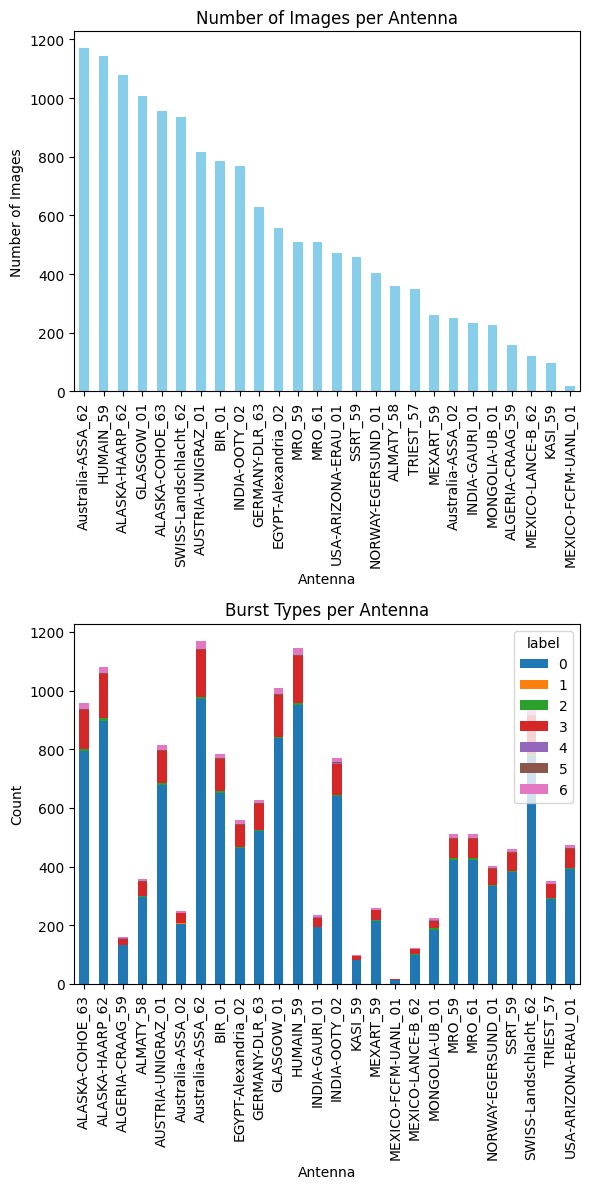

In [120]:
# EDA
import matplotlib.pyplot as plt
# Number of images per antenna
images_per_antenna = test_df['antenna'].value_counts()

# Number of burst types per antenna
burst_types_per_antenna = test_df.groupby('antenna')['label'].value_counts().unstack(fill_value=0)

# Date range per antenna
date_range_per_antenna = test_df.groupby('antenna')['datetime'].agg([min, max])

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(6, 12))

# Images per antenna
images_per_antenna.plot(kind='bar', ax=ax[0], color='skyblue')
ax[0].set_title('Number of Images per Antenna')
ax[0].set_xlabel('Antenna')
ax[0].set_ylabel('Number of Images')

# Burst types per antenna
burst_types_per_antenna.plot(kind='bar', stacked=True, ax=ax[1])
ax[1].set_title('Burst Types per Antenna')
ax[1].set_xlabel('Antenna')
ax[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [113]:
from datasets import load_dataset
train = load_dataset('csv', data_files='/mnt/nas05/data01/vincenzo/ecallisto/data/train_metadata.csv')
valid = load_dataset('csv', data_files='/mnt/nas05/data01/vincenzo/ecallisto/data/val_metadata.csv')
test = load_dataset('csv', data_files='/mnt/nas05/data01/vincenzo/ecallisto/data/test_metadata.csv')

Generating train split: 113409 examples [00:00, 388483.66 examples/s]
Generating train split: 14253 examples [00:00, 353943.52 examples/s]
Generating train split: 14271 examples [00:00, 365061.31 examples/s]


In [114]:
from datasets import Image
train = train.cast_column("image", Image())
valid = valid.cast_column("image", Image())
test = test.cast_column("image", Image())

In [115]:
from datasets import DatasetDict
dd = DatasetDict({"train": train['train'],"validation": valid['train'], "test":test['train']})

In [116]:
dd.push_to_hub('i4ds/radio-sunburst-ecallisto')

Uploading the dataset shards: 100%|██████████| 1/1 [00:26<00:00, 26.73s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/i4ds/radio-sunburst-ecallisto/commit/6f6a2442323034804ff2e58048d467455ebdedd2', commit_message='Upload dataset', commit_description='', oid='6f6a2442323034804ff2e58048d467455ebdedd2', pr_url=None, pr_revision=None, pr_num=None)

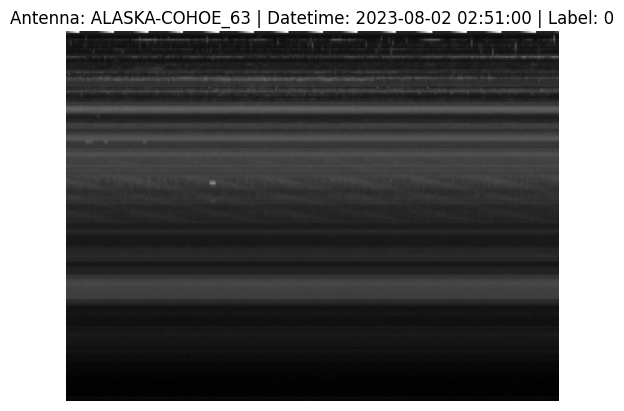

In [123]:
# Display the image
plt.imshow(dd['train'][7]['image'], cmap='gray')  # 'gray' colormap for mode=L (grayscale)
plt.title(f"Antenna: {dd['train'][7]['antenna']} | Datetime: {dd['train'][7]['datetime']} | Label: {dd['train'][7]['label']}")
plt.axis('off')  # Turn off the axis
plt.show()